# GRABEN

In [1]:
import sys
sys.path.append("../../gempy")
sys.path.append("../../pynoddy")
import copy
import importlib

import numpy as np
import pandas as pn
import math

import gempy as gp
from gempy import Topology as tp

import pynoddy
import pynoddy.history
import pynoddy.output
import pynoddy.events
import pynoddy.experiment

import matplotlib.pyplot as plt
%matplotlib inline

import pymc
import theano

# Data Import

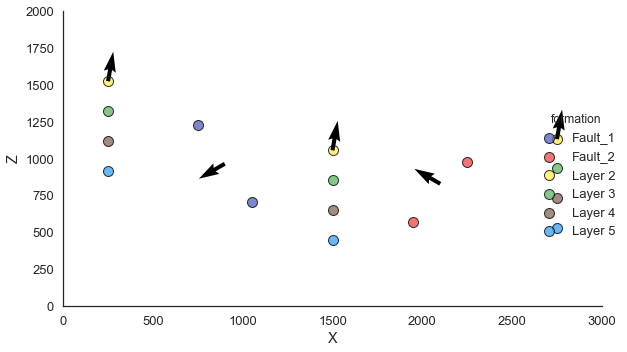

In [2]:
# geo_data = gp.read_pickle("exp1_data.pickle")

# initialize geo_data object
geo_data = gp.create_data([0, 3000, 0, 75, 0, 2000],
                          resolution=[120, 3, 80])

geo_data.import_data_csv("data/exp1_graben_interf.csv", "data/exp1_graben_fol.csv")
geo_data.calculate_gradient()

form = np.delete(geo_data.get_formations(), np.where(geo_data.get_formations()=="Fault_1")[0][0])
gp.set_series(geo_data, {"Fault_1":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_1")[0][0]],
                         "Fault_2":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_2")[0][0]],
                         "Rest":np.delete(form, np.where(form=="Fault_2"))},
                           order_series = ["Fault_1", "Fault_2", "Rest"], verbose=0, order_formations=['Fault_1', "Fault_2",'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5'])

geo_data.set_formation_number()
geo_data.order_table()

%matplotlib inline
gp.plot_data(geo_data)
plt.xlim(0,3000)
plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig("input_data.pdf")

In [14]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[0,0,3], dtype="float64", verbose=['matrices_shapes', 'faults_contribution'])
lith_block, fault_block = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
length_of_C __str__ = 4
length_of_CG __str__ = 3
length_of_CGI __str__ = 1
length_of_U_I __str__ = 0
length_of_faults __str__ = 0
f_sle __str__ = []
Faults nfc __str__ = 28820
Faults contribution __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
length_of_C __str__ = 4
length_of_CG __str__ = 3
length_of_CGI __str__ = 1
length_of_U_I __str__ = 0
length_of_faults __str__ = 0
f_sle __str__ = []
Faults nfc __str__ = 20336
Faults contribution __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
length_of_C __str__ = 21
length_of_CG __str__ = 9
length_of_CGI __str__ = 8
length_of_U_I __str__ = 3
length_of_faults __str__ = 1
f_sle __str__ = [[ 2.  2.  2. ...,  3.  3.  3.]]
Faults nfc __str__ = 28820
Faults contribution __str__ = [ 0.11876896  0.11876896  0.11876896 ...,  0.17815344  0.17815344
  0.17815344]
length_of_C __str__ = 4
length_of_CG __str__ = 3
length_of_CGI __str__ = 1
length_of_U_I __str__ = 0
length_of_faults __str__ = 0
f_sle __s

Labels & Stuff:

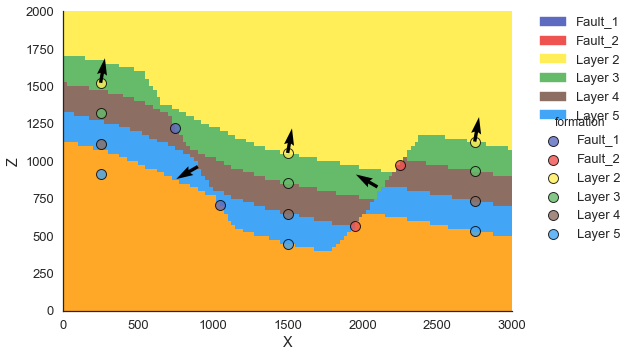

In [11]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 0, plot_data=True)
#plt.savefig("exp1_graben_model_w_input_data.pdf")

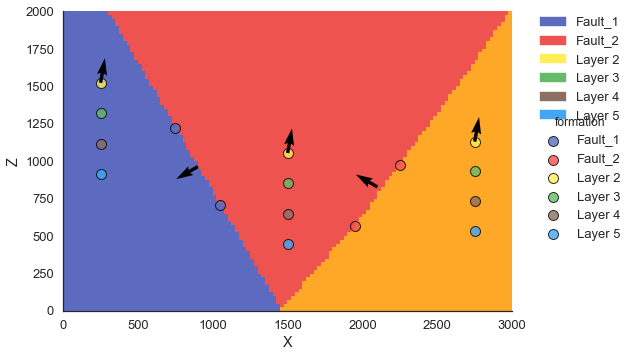

In [5]:
gp.plot_section(geo_data, fault_block[0], 0, plot_data=True)

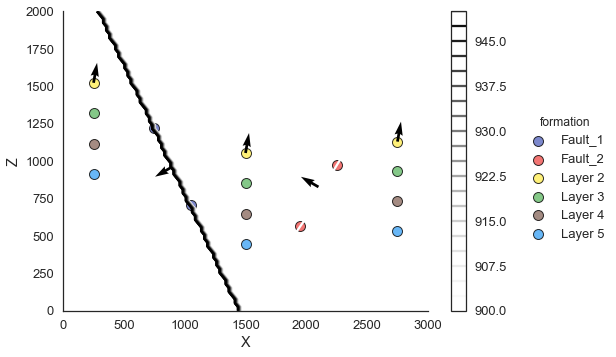

In [8]:
gp.plot_potential_field(geo_data, fault_block[1], 1, plot_data=True)
plt.colorbar()

In [9]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)
gp.plot_surfaces_3D(geo_data, ver, sim, alpha=1)

NameError: name 'vtk' is not defined

In [15]:
group_ids = np.unique(geo_data.interfaces["group_id"])
layer_ids = group_ids[group_ids!="Fault_1"]
layer_ids = group_ids[group_ids!="Fault_2"]
layer_ids_u = [l[:-2] for l in layer_ids]
layer_ids_u = np.unique(layer_ids_u)

# PYMC Implementation

## Priors

Create pymc.Normal distributions (mean 0) as prior parameters for the layer interface positions (modifier):

In [16]:
geo_data.interfaces

,X,Y,Z,formation,series,X_std,Y_std,Z_std,group_id,order_series,isFault,formation number,annotations
0,750,0,1223,Fault_1,Fault_1,0.0,0.0,0.0,Fault_1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,1050,0,704,Fault_1,Fault_1,0.0,0.0,0.0,Fault_1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,2250,0,975,Fault_2,Fault_2,0.0,0.0,0.0,Fault_2,2,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
3,1950,0,567,Fault_2,Fault_2,0.0,0.0,0.0,Fault_2,2,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
4,250,0,1523,Layer 2,Rest,0.0,0.0,0.0,l2_a,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$"
5,1500,0,1054,Layer 2,Rest,0.0,0.0,0.0,l2_b,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$"
6,2750,0,1130,Layer 2,Rest,0.0,0.0,0.0,l2_c,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$"
7,250,0,1320,Layer 3,Rest,0.0,0.0,0.0,l3_a,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$"
8,1500,0,851,Layer 3,Rest,0.0,0.0,0.0,l3_b,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},1}$"
9,2750,0,936,Layer 3,Rest,0.0,0.0,0.0,l3_c,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},2}$"


In [17]:
interp_data.geo_data_res.foliations

,X,Y,Z,dip,azimuth,polarity,formation,G_x,G_y,G_z,series,order_series,isFault,formation number,annotations,group_id
0,0.3801,0.5001,0.4959,60,90,-1,Fault_1,-0.866025,-5.302876e-17,-0.500000,Fault_1,1,True,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$",Fault_1
1,0.6201,0.5001,0.4687,60,270,1,Fault_2,-0.866025,-1.590863e-16,0.500000,Fault_2,2,True,2,"${\bf{x}}_{\beta \,{\bf{2}},0}$",Fault_2
2,0.2501,0.5001,0.6079,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},0}$",l2_a
3,0.5001,0.5001,0.5141,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},1}$",l2_b
4,0.7501,0.5001,0.5293,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},2}$",l2_c


In [18]:
interf_Z_modifier = []
interf_Z_std = 40.

for g_id in ['l2', 'l3', 'l4', 'l5']:
    interf_Z_modifier.append(pymc.Normal(g_id, 0, 1./interf_Z_std**2))
    
fault_1_dip = pymc.Normal("fault_1_dip", 60., 1./5**2)
fault_2_dip = pymc.Normal("fault_2_dip", 60., 1./5**2)
strat_dip = pymc.Normal("strat_dip", 15., 1./5**2)

For the fault we only want to change the dip angle, so we create a PlaneData object:

In [19]:
# first we remove the initial fault foliation
try:
    i = geo_data.foliations[geo_data.foliations["formation"]=="Fault_1"].index
    geo_data.foliations.drop(i, inplace=True)
    i = geo_data.foliations[geo_data.foliations["formation"]=="Fault_2"].index
    geo_data.foliations.drop(i, inplace=True)
except ValueError:
    pass
# then create it coupled with the interface points
fault_plane_1 = gp.DataManagement.DataPlane(geo_data, "Fault_1", "interf_to_fol")
fault_plane_1.set_fol()
fault_plane_2 = gp.DataManagement.DataPlane(geo_data, "Fault_2", "interf_to_fol")
fault_plane_2.set_fol()

Visualize the distribution:

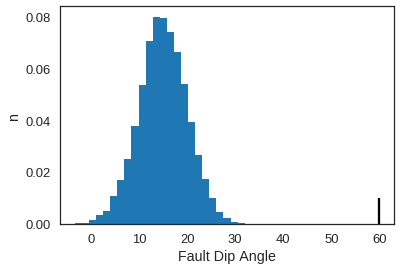

In [20]:
# sample from a distribtion
samples = [strat_dip.rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Fault Dip Angle")
plt.vlines(60, 0, 0.01)
#plt.xlim(40, 80)
plt.ylabel("n");

Reset series, somehow this gets messed up above - fix!

,X,Y,Z,dip,azimuth,polarity,formation,G_x,G_y,G_z,series,order_series,isFault,formation number,annotations,group_id
0,0.3801,0.5001,0.4959,60,90,-1,Fault_1,-0.866025,-5.302876e-17,-0.500000,Fault_1,1,True,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$",Fault_1
1,0.6201,0.5001,0.4687,60,270,1,Fault_2,-0.866025,-1.590863e-16,0.500000,Fault_2,2,True,2,"${\bf{x}}_{\beta \,{\bf{2}},0}$",Fault_2
2,0.2501,0.5001,0.6079,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},0}$",l2_a
3,0.5001,0.5001,0.5141,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},1}$",l2_b
4,0.7501,0.5001,0.5293,10,90,1,Layer 2,0.173648,1.063288e-17,0.984808,Rest,3,False,3,"${\bf{x}}_{\beta \,{\bf{3}},2}$",l2_c


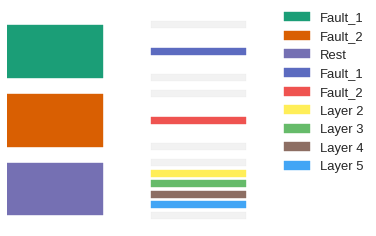

In [21]:
form = np.delete(geo_data.get_formations(), np.where(geo_data.get_formations()=="Fault_1")[0][0])
gp.set_series(geo_data, {"Fault_1":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_1")[0][0]],
                         "Fault_2":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_2")[0][0]],
                         "Rest":np.delete(form, np.where(form=="Fault_2"))},
                           order_series = ["Fault_1", "Fault_2", "Rest"], verbose=0, order_formations=['Fault_1', "Fault_2",'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5'])

geo_data.set_formation_number()
geo_data.order_table()

interp_data.geo_data_res.foliations.set_value(0, "group_id", "Fault_1")
interp_data.geo_data_res.foliations.set_value(1, "group_id", "Fault_2")
interp_data.geo_data_res.foliations.set_value(2, "group_id", "l2_a")
interp_data.geo_data_res.foliations.set_value(3, "group_id", "l2_b")
interp_data.geo_data_res.foliations.set_value(4, "group_id", "l2_c")

interp_data_original.geo_data_res.foliations.set_value(0, "group_id", "Fault_1")
interp_data_original.geo_data_res.foliations.set_value(1, "group_id", "Fault_2")
interp_data_original.geo_data_res.foliations.set_value(2, "group_id", "l2_a")
interp_data_original.geo_data_res.foliations.set_value(3, "group_id", "l2_b")
interp_data_original.geo_data_res.foliations.set_value(4, "group_id", "l2_c")

## Deterministic Functions

### Utility Functions

In [22]:
def rescale(value, rf=interp_data.rescaling_factor):
    return value / rf

def recalc_gradients(folations_dataframe):
    folations_dataframe["G_x"] = np.sin(np.deg2rad(folations_dataframe["dip"].astype('float'))) * \
                             np.sin(np.deg2rad(folations_dataframe["azimuth"].astype('float'))) * \
                             folations_dataframe["polarity"].astype('float')
    folations_dataframe["G_y"] = np.sin(np.deg2rad(folations_dataframe["dip"].astype('float'))) * \
                             np.cos(np.deg2rad(folations_dataframe["azimuth"].astype('float'))) *\
                             folations_dataframe["polarity"].astype('float')
    folations_dataframe["G_z"] = np.cos(np.deg2rad(folations_dataframe["dip"].astype('float'))) *\
                             folations_dataframe["polarity"].astype('float')

Create Plane object for fault plane:

In [23]:
from gempy import UncertaintyAnalysisPYMC2
importlib.reload(UncertaintyAnalysisPYMC2)
fault_plane1 = UncertaintyAnalysisPYMC2.Plane("Fault_1", interp_data.geo_data_res)
fault_plane2 = UncertaintyAnalysisPYMC2.Plane("Fault_2", interp_data.geo_data_res)

### Input data handling

In [24]:
layer_ids_u = np.delete(layer_ids_u, np.where(layer_ids_u=="Fault"))

In [41]:
interp_data.geo_data_res.interfaces

,X,Y,Z,formation,series,X_std,Y_std,Z_std,group_id,order_series,isFault,formation number,annotations
0,0.3501,0.5001,0.558347,Fault_1,Fault_1,0.0,0.0,0.0,Fault_1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,0.4101,0.5001,0.433453,Fault_1,Fault_1,0.0,0.0,0.0,Fault_1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,0.6501,0.5001,0.516531,Fault_2,Fault_2,0.0,0.0,0.0,Fault_2,2,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
3,0.5901,0.5001,0.420869,Fault_2,Fault_2,0.0,0.0,0.0,Fault_2,2,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
4,0.2501,0.5001,0.595965,Layer 2,Rest,0.0,0.0,0.0,l2_a,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$"
5,0.5001,0.5001,0.502165,Layer 2,Rest,0.0,0.0,0.0,l2_b,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$"
6,0.7501,0.5001,0.517365,Layer 2,Rest,0.0,0.0,0.0,l2_c,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$"
7,0.2501,0.5001,0.561564,Layer 3,Rest,0.0,0.0,0.0,l3_a,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$"
8,0.5001,0.5001,0.467764,Layer 3,Rest,0.0,0.0,0.0,l3_b,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},1}$"
9,0.7501,0.5001,0.484764,Layer 3,Rest,0.0,0.0,0.0,l3_c,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},2}$"


In [42]:
layer_ids_u

array(['l2', 'l3', 'l4', 'l5'],
      dtype='<U5')

In [46]:
@pymc.deterministic(trace=True)
def input_data(value = 0,
               interf_Z_modifier = interf_Z_modifier,
               strat_dip = strat_dip,
               fault_1_dip = fault_1_dip,
               fault_2_dip = fault_2_dip,
               fault_plane1 = fault_plane1,
               fault_plane2 = fault_plane2,
               group_ids = group_ids,
               layer_ids = layer_ids,
               layer_ids_u = layer_ids_u,
               interp_data = interp_data,
               interp_data_original = interp_data_original,
               verbose=True):

    # reset data in geo_data_res to geo_data 
    # (this now includes the updated fault plane data)
    interp_data.geo_data_res = copy.deepcopy(interp_data_original.geo_data_res)
    #interp_data_stoch = gp.get_data(interp_data.geo_data_res, numeric=True)
    if verbose is True:
        #print(interp_data_stoch)
        print(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float))
        print(interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype(float))
    
    fault_plane1 = UncertaintyAnalysisPYMC2.Plane("Fault_1", interp_data.geo_data_res)
    fault_plane2 = UncertaintyAnalysisPYMC2.Plane("Fault_2", interp_data.geo_data_res)
    # fault plane
    if verbose == "dip":
        print(interp_data.geo_data_res.foliations["dip"])
    
    fault_plane1.interf_recalc_Z(fault_1_dip)
    fault_plane2.interf_recalc_Z(fault_2_dip)
    
    if verbose == "dip":
        print(interp_data.geo_data_res.foliations["dip"])
    
    # interf dip
    for affix in ["_a", "_b", "_c"]:
        f = interp_data.geo_data_res.foliations["group_id"] == "l2" + affix
        index = interp_data.geo_data_res.foliations[f].index
        interp_data.geo_data_res.foliations.set_value(index, "dip", int(strat_dip))
    recalc_gradients(interp_data.geo_data_res.foliations)
    
    # interf vertical mod
    for i, layer_id in enumerate(layer_ids_u):
        for affix in ["_a", "_b", "_c"]:
            # interface positions
            f = interp_data.geo_data_res.interfaces["group_id"] == layer_id + affix
            index = interp_data.geo_data_res.interfaces[f].index
            # get the z value of the interface
            vals = interp_data.geo_data_res.interfaces.iloc[index]["Z"].astype(float).values
            if verbose is True:
                print("vals of ",layer_id,affix,vals)
                
            # modify it with the according rescaled prior
            vals += rescale(interf_Z_modifier[i])
            if verbose is True:
                print("vals mod:",rescale(interf_Z_modifier[i]))
            # replace value
            interp_data.geo_data_res.interfaces.set_value(index, "Z", vals)
            if verbose is True:
                print("modded val:",interp_data.geo_data_res.interfaces.iloc[index]["Z"])
            
            # foliation positions
            f = interp_data.geo_data_res.foliations["group_id"] == layer_id + affix
            index = interp_data.geo_data_res.foliations[f].index
            # get the z value of the interface
            vals = interp_data.geo_data_res.foliations.iloc[index]["Z"].astype(float).values
            # modify it with the according rescaled prior
            vals += rescale(interf_Z_modifier[i])
            # replace value
            interp_data.geo_data_res.foliations.set_value(index, "Z", vals) 
            
    interp_data.update_interpolator()
    
    if verbose is True:
        print(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float))
        print(interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype("float64"))
    
    return [interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float), 
            interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype("float64")]

         X       Y       Z
0   0.3501  0.5001  0.5479
1   0.4101  0.5001  0.4441
2   0.6501  0.5001  0.4983
3   0.5901  0.5001  0.4167
4   0.2501  0.5001  0.6079
5   0.5001  0.5001  0.5141
6   0.7501  0.5001  0.5293
7   0.2501  0.5001  0.5673
8   0.5001  0.5001  0.4735
9   0.7501  0.5001  0.4905
10  0.2501  0.5001  0.5267
11  0.5001  0.5001  0.4329
12  0.7501  0.5001  0.4499
13  0.2501  0.5001  0.4861
14  0.5001  0.5001  0.3923
15  0.7501  0.5001  0.4093
        G_x           G_y       G_z       X       Y       Z  azimuth   dip  \
0 -0.866025 -5.302876e-17 -0.500000  0.3801  0.5001  0.4959     90.0  60.0   
1 -0.866025 -1.590863e-16  0.500000  0.6201  0.5001  0.4687    270.0  60.0   
2  0.173648  1.063288e-17  0.984808  0.2501  0.5001  0.6079     90.0  10.0   
3  0.173648  1.063288e-17  0.984808  0.5001  0.5001  0.5141     90.0  10.0   
4  0.173648  1.063288e-17  0.984808  0.7501  0.5001  0.5293     90.0  10.0   

   polarity  
0      -1.0  
1       1.0  
2       1.0  
3       1.0  
4 

### GemPy modeling function

In [26]:
gp.get_kriging_parameters(interp_data)

range 0.7212662476506163 3606.33123825
Number of drift equations [0 0 3]
Covariance at 0 0.012386309523809529
Foliations nugget effect 0.01


In [27]:
%matplotlib inline
# interp_data.update_interpolator(geo_data_res=interp_data.geo_data_res, range_var=0.9)
@pymc.deterministic(trace=False)  # turn on/off storing the model blocks in db
def gempy_model(value=0,
                input_data=input_data,
                verbose=False):
    
    # modify input data values accordingly
    # interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    # interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]] = input_data[1]
    
    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        if verbose:
            gp.plot_section(interp_data.geo_data_res, lb[0], 0, plot_data=False)
            
        return lb, fb
    
    except numpy.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
            
        return np.zeros_like(lith_block), np.zeros_like(fault_block)

### Topology function

In [29]:
@pymc.deterministic
def gempy_topo(value=0, gm=gempy_model, verbose=False):
    
    G, c, lu, lot1, lot2 = gp.topology_compute(geo_data, gm[0][0], gm[1][0], 
                                               cell_number=0, direction="y")
    
    if verbose:
        gp.plot_section(geo_data, gm[0][0], 0)
        gp.topology_plot(geo_data, G, c)
    return G, c, lu, lot1, lot2

# Likelihood Functions

In [30]:
sys.path.append("../")
from pynoddy.experiment import pymc2_posterior

importlib.reload(pymc2_posterior)
importlib.reload(pynoddy.history)
pp = pymc2_posterior.Pymc2Posterior("pyn_graben_run4.hdf5")
# pp.topo_analyze()

Unable to load pynoddy block models. Either none were tallied or the respective pymc2 deterministic function is not named 'pynoddy_model'. If so change 'pymc_model_f' parameter accordingly.


In [31]:
pp.set_history("init4.his")
pp.set_experiment()

History file set to self.history


In [32]:
pp.topo_analyze()

Starting topology analysis. This could take a while (depending on # iterations).
Topology analysis completed.


In [33]:
pp.topo_count_connection(4,7)/pp.db.getstate()["sampler"]["_iter"] * 100

20.09

## Single Adjacency Area Likelihood

In [23]:
def get_areas_for_edge_for_topo_id(pp_obj, topo_id, n1, n2):
    """Get all area values for edge n1--n2 from a certain topo_id."""
    areas = np.array([])
    for i in np.where(pp.topo_unique_ids == topo_id)[0]:
        try:
            a = pp_obj.topo_graphs[i].adj[n1][n2]["area"]
            areas = np.append(areas, a)
        except KeyError:
            # edge does not exist -> set 0 as adjacency area
            a = 0.
            areas = np.append(areas, a)
            # continue
    return areas

def get_all_possible_edges(topos):
    """Get all occuring edges throughout all graphs in list/array."""
    storage = []
    for graph in topos:
        for edge in graph.edges():
            if edge in storage:
                continue
            else:
                storage.append(edge)
    return storage

def combined_areas_for_all_topo_ids(edge_areas, edge):
    storage = np.array([])
    for i in range(len(edge_areas)):
        storage = np.append(storage, edge_areas[i][edge])
    return storage

In [24]:
def get_area_for_edge(G, e):
    """Get adjacency area of edge e (a, b) in graph G. 
    Returns 0 if no edge/area exists."""
    try:
        return G.adj[e[0]][e[1]]["area"]
    except KeyError:
        return 0

def get_area_for_edge_all(graphs, e):
    """e = (a, b) edge"""
    areas = np.array([])
    for G in graphs:
        areas = np.append(areas, get_area_for_edge(G, e))
    return areas

In [25]:
edges = [(4,7), (4,8), (4,9),
         (3,7), (3,8), (3,9),
         (2,7), (2,8), (2,9),
         (7,14), (7,13), (7,12),
         (8,14), (8,13), (8,12),
         (9,14), (9,13), (9,12)]

In [26]:
from sklearn.neighbors import KernelDensity

In [27]:
kde_list = []
for e in edges:
    a = get_area_for_edge_all(pp.topo_graphs, e)
    kde_list.append(KernelDensity(kernel="gaussian").fit(a.reshape(-1, 1)))

### fix pymc

In [ ]:
def stochastic_from_data(name, data, lower=-np.inf, upper=np.inf,
                         value=None, observed=False, trace=True, verbose=-1, debug=False):
    """
    Return a Stochastic subclass made from arbitrary data.

    The histogram for the data is fitted with Kernel Density Estimation.

    :Parameters:
      - `data`  : An array with samples (e.g. trace[:])
      - `lower` : Lower bound on possible outcomes
      - `upper` : Upper bound on possible outcomes

    :Example:
       >>> from pymc import stochastic_from_data
       >>> pos = stochastic_from_data('posterior', posterior_samples)
       >>> prior = pos # update the prior with arbitrary distributions

    :Alias:
      Histogram
    """
    pdf = scipy.stats.kde.gaussian_kde(data)  # automatic bandwidth selection

    # account for tail contribution
    lower_tail = upper_tail = 0.
    if lower > -np.inf:
        lower_tail = pdf.integrate_box(-np.inf, lower)
    if upper < np.inf:
        upper_tail = pdf.integrate_box(upper, np.inf)
    factor = 1. / (1. - (lower_tail + upper_tail))

    def logp(value):
        prob = factor * pdf(value)
        if value < lower or value > upper:
            return -np.inf
        elif prob <= 0.:
            return -np.inf
        else:
            return np.log(prob)

    def random():
        res = pdf.resample(1)[0][0]
        while res < lower or res > upper:
            res = pdf.resample(1)[0][0]
        return res

    if value is None:
        value = random()

    return pymc.Stochastic(logp=logp,
                      doc='Non-parametric density with Gaussian Kernels.',
                      name=name,
                      parents={},
                      random=random,
                      trace=trace,
                      value=value,
                      dtype=float,
                      observed=observed,
                      verbose=verbose)


# Alias following Stochastics naming convention
Histogram = stochastic_from_data

create likelihood functions:

In [28]:
like_list = []
for e in edges:
    a = get_area_for_edge_all(pp.topo_graphs, e)
    #like_list.append(stochastic_from_data("like_"+str(e[0])+"_"+str(e[1]), a, lower=0, value=get_area_for_edge(gempy_topo_extract.value, e)))
    like_list.append(pymc.Normal("like_"+str(e[0])+"_"+str(e[1]), mu=get_area_for_edge(gempy_topo_extract.value, e), tau=1./np.std(a)**2, observed=True, value=a))

In [29]:
like_list

[<pymc.distributions.new_dist_class.<locals>.new_class 'like_4_7' at 0x7fa0958702b0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_4_8' at 0x7fa095870e10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_4_9' at 0x7fa0959374e0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_3_7' at 0x7fa095937278>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_3_8' at 0x7fa095937390>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_3_9' at 0x7fa0959375c0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_2_7' at 0x7fa095937240>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_2_8' at 0x7fa095937dd8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_2_9' at 0x7fa086f41c18>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_7_14' at 0x7fa086f41be0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'like_7_13' at 0x7fa086f41cf8>,
 <pymc.distributions.new_dist_class.<locals>.new_cla

In [39]:
len(edges)

18

In [28]:
@pymc.stochastic
def like_area_edge_0(value=0, i=0, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_1(value=0, i=1, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_2(value=0, i=2, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_3(value=0, i=3, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_4(value=0, i=4, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_5(value=0, i=5, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_6(value=0, i=6, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_7(value=0, i=7, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_8(value=0, i=8, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_9(value=0, i=9, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_10(value=0, i=10, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_11(value=0, i=11, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_12(value=0, i=12, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_13(value=0, i=13, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_14(value=0, i=14, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_15(value=0, i=15, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_16(value=0, i=16, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_17(value=0, i=17, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

In [29]:
like_list = [like_area_edge_0, 
             like_area_edge_1,
             like_area_edge_2,
             like_area_edge_3,
             like_area_edge_4,
            like_area_edge_5,
            like_area_edge_6,
            like_area_edge_7,
            like_area_edge_8,
            like_area_edge_9,
            like_area_edge_10,
            like_area_edge_11,
             like_area_edge_12,
             like_area_edge_13,
             like_area_edge_14,
            like_area_edge_15,
            like_area_edge_16,
            like_area_edge_17]

### KDE

In [110]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

In [125]:
kde = KernelDensity(kernel="gaussian").fit(areas.reshape(-1, 1))
#kde2 = KernelDensity(kernel="tophat").fit(areas.reshape(-1, 1))

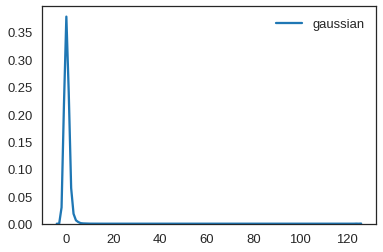

In [126]:
#samples2 = kde2.sample(n_samples=50000)
#sns.distplot(samples2, label="tophat", hist=False)


In [42]:
kde.score(0)

-1.047478816587871

In [50]:
kde.score(10)

-5.0586295146823463

In [61]:
@pymc.stochastic
def like_single_adj_area(value=0, n1=n1, n2=n2, kde=kde, G=gempy_topo[0]):
    try:
        area = G.adj[n1][n2]["area"]
        return kde.score(area)
    except KeyError:
        # if not connected
        return kde.score(0)

8

## Plot

## Graph Comparison: Direct Jaccard Coefficient Comparison with most-likely kinematic topology graph

In [34]:
def compare_graphs(G1, G2):
    intersection = 0
    union = G1.number_of_edges()

    for edge in G1.edges_iter():
        if G2.has_edge(edge[0], edge[1]):
            intersection += 1
        else:
            union += 1

    return intersection / union

In [ ]:
G = copy.copy(pp.topo_graphs[0])

### Probabilistic Graph Comparison ?

In [41]:
pp.topo_unique_freq = np.array(pp.topo_unique_freq)
pp.topo_unique = np.array(pp.topo_unique)
booly = pp.topo_unique_freq<10

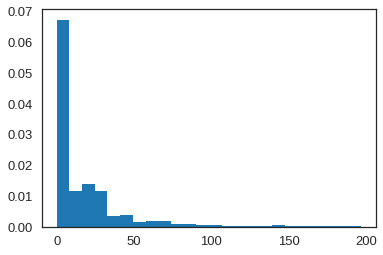

In [43]:
plt.hist(pp.topo_unique_ids, normed=True, bins=24);

In [25]:
@pymc.stochastic
def like_topo_all(value=0,
                  gt = gempy_topo,
                  topo_unique=pp.topo_unique,#[booly],
                  topo_unique_prob=pp.topo_unique_prob,#[booly], 
                  verbose=False):
    
    # check gp_topo against unique topos
    try:
        for i, tu in enumerate(topo_unique):
            j = compare_graphs(gt[0], tu)
            if verbose:
                print(i, "j:", j)
            if j == 1.:  # this is a match
                if verbose:
                    print(np.log(topo_unique_prob[i]))
                return np.log(topo_unique_prob[i])

        if verbose:
            print("no match:", np.log(1e-99))
        return np.log(1e-99)
    except ZeroDivisionError:
        return np.log(1e-99)

In [35]:
@pymc.stochastic
def like_topo_single(value=0,
                     gt = gempy_topo,
                     topo_like_graph = pp.topo_unique[0],
                     verbose=False):
    # checks model against single graph likelihood
    try:
        j = compare_graphs(gt[0], topo_like_graph)
        if j == 1.:
            return np.log(0.95)
        else:
            return np.log(0.05)
    except ZeroDivisionError:
        return np.log(1e-99)

In [52]:
@pymc.stochastic
def like_topo_single_edge(value=0,
                          gt = gempy_topo,
                          verbose=False):
    return pymc.bernoulli_like(7 in gt[0].adj[4].keys(), 0.95)        

### Centroid Position Likelihood

## pymc Model Set-Up

In [36]:
params = [input_data, gempy_model, *interf_Z_modifier, fault_1_dip, fault_2_dip, strat_dip, gempy_topo, like_topo_single]#,*like_list, like_single_adj_area]#like_topo_single]#, like_topo_all] # like_jaccard_cauchy]
model = pymc.Model(params)

In [37]:
iterations = 2100

In [38]:
RUN = pymc.MCMC(model, db="hdf5", dbname="simulations/exp1_graben_BI_jaccard_topo_single")  # exp1_id_2_BI_9_combined_topo

In [39]:
RUN.sample(iter=iterations, burn=100, tune_interval=20)

 [-----------------100%-----------------] 2101 of 2100 complete in 12593.0 sec

## Check

Plotting fault_2_dip
Plotting l3
Plotting l4
Plotting l5
Plotting strat_dip
Plotting like_topo_single
Plotting fault_1_dip
Plotting l2


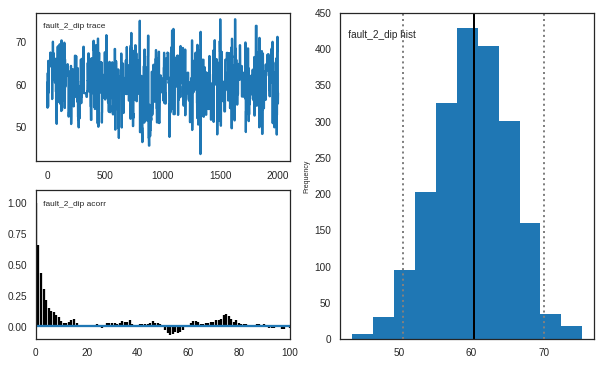

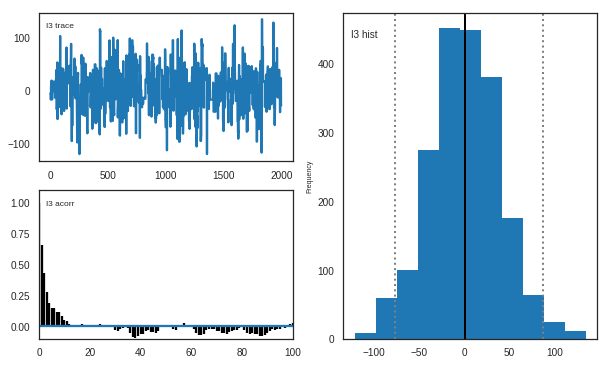

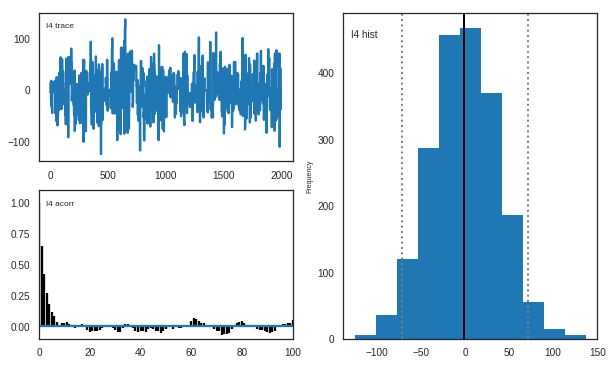

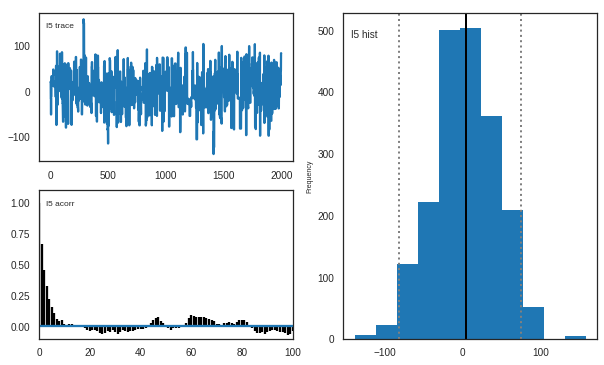

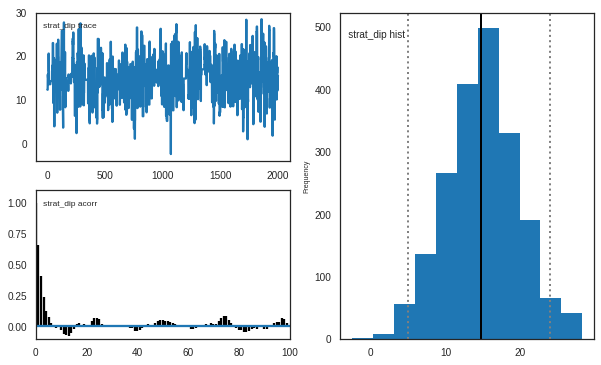

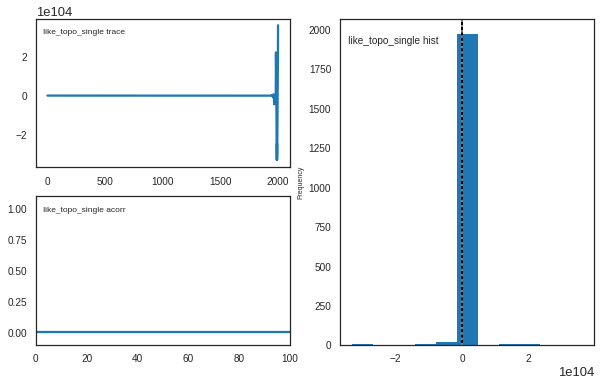

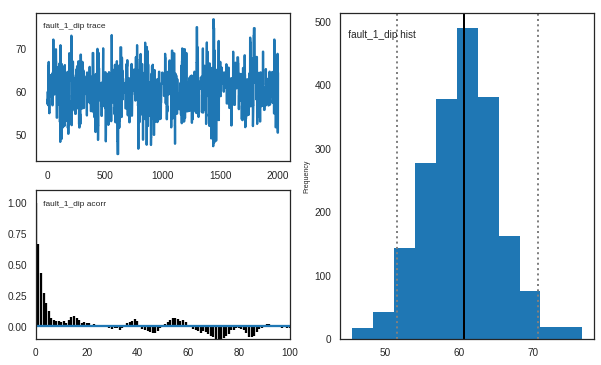

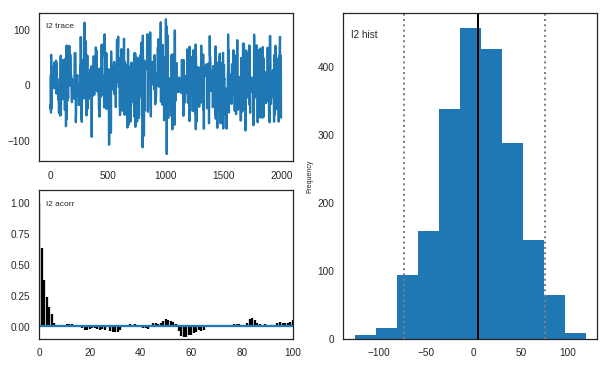

In [40]:
pymc.Matplot.plot(RUN)

In [68]:
from scipy import stats

In [69]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,np.log())

In [74]:
np.polyfit(x, np.log(RUN.trace("like_topo_all")[:]),1)

array([ nan,  nan])

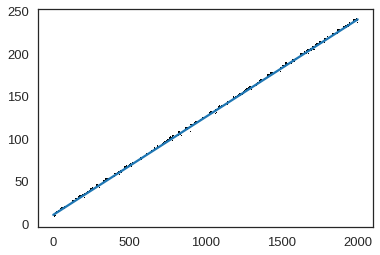

In [85]:
%matplotlib inline
a = [i/8.7+10 for i in range(2000)]
plt.plot(np.log(RUN.trace("like_topo_all")[:]), "k,")
plt.plot(x,a)